# **Shell.ai Hackathon for Sustainable and Affordable Energy (Agricultural Waste Challenge)**


## **Problem Introduction**
To set up a biorefinery in a region, an understanding of the region’s current and future biomass produce will be required. This biomass needs to be collected and transported to intermediate depots for de-moisturisation and densification into pellets. The pellets will then need to be transported to the biorefinery for conversion to biofuel. This incurs high cost of feedstock transportation and associated GHG emissions, which will need to be minimised too.1 The value it generates lies not only in contribution to the global energy transition, but also benefits farmers as a sustainable source of income.

## **Proble Statement**
In this hackathon, we challenge you to form teams, brainstorm ideas, and build digital solutions that can design and optimise this new, complex, and strategic supply chain for biorefineries of the future.

## **About Gujarat**
Gujarat  is a state along the western coast of India. Its coastline of about 1,600 km (990 mi) is the longest in the country, most of which lies on the Kathiawar peninsula. Gujarat is the fifth-largest Indian state by area, covering some 196,024 km2 (75,685 sq mi); and the ninth-most populous state, with a population of 60.4 million.

Gujarat's capital city is Gandhinagar, while its largest city is Ahmedabad.

# **SETUP**

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
file_path = "/content/drive/MyDrive/ShellAIHack/"

In [29]:
%%capture
!pip install pulp

# **Libraries**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tqdm

import warnings
warnings.filterwarnings("ignore")

## Libraries
import pulp
import json

import math
from sklearn.cluster import KMeans

In [31]:
import os

import matplotlib.pyplot as plt
import seaborn as supplyPoints_coordinates
import statsmodels.api as sm
import xgboost as xgb

plt.style.use('fivethirtyeight')

In [32]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import KFold

## **UTILS**

**Visualize**

In [33]:
"""
Created on:
@author   :

NAME
  visualize.py

DESCRIPTION
    Visualizes Longitude, Latitude and Biomass demand data
    ============================================================

PACKAGE LIST
  pandas
  matplotlib
"""

## Libraries
import pandas as pd
import matplotlib.pyplot as plt

def plot_map(df,
             year,
             depot_data = None,
             refinery_data = None,
             cluster_col = None):

  """
  Plotting biomass harvesting points and depot points.

  This function takes a DataFrame containing information about biomass harvesting points
  and depot points and generates a plot to visualize their locations on a map.

  Parameters:
      dataframe (pd.DataFrame): A pandas DataFrame containing the following columns:
                                  - 'Latitude': Latitude values of the points.
                                  - 'Longitude': Longitude values of the points.
                                  - Yearly Biomass demand
  Returns:
    None
  """
  title = "Harvesting, "
  plt.figure(figsize = (50,30))

  colorList = [
      'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'navy', 'purple', 'teal', 'lime', 'aqua',
      'fuchsia', 'olive', 'maroon', 'silver', 'gray', 'lightgray', 'darkgray', 'coral']

  if cluster_col:
    n_clusters = df[cluster_col].unique()
    for cluster in n_clusters:
      DemandSize = df[df[cluster_col].eq(cluster)][f"{year}"]
      plt.scatter(df[df[cluster_col].eq(cluster)]["Longitude"], df[df[cluster_col].eq(cluster)]["Latitude"],
                  label = f"Harvesting Points cluster {cluster}", marker ="*", color = colorList[cluster], s = DemandSize)
  else:
    DemandSize = df[f"{year}"]
    plt.scatter(df["Longitude"], df["Latitude"], label = f"Harvesting Points", marker ="*",
                color = "b", s = DemandSize)

  if isinstance(depot_data, pd.DataFrame):
    plt.scatter(depot_data["Longitude"], depot_data["Latitude"], label = "Depots Points", marker ="s",color = "green", s = 1000)
    title += "Depots, "

  if isinstance(refinery_data, pd.DataFrame):
    plt.scatter(refinery_data["Longitude"], refinery_data["Latitude"], label = "Refinery Points", marker ="o",color = "red", s = 1500)
    title += "Rifineries, "

  title += "Locations"
  plt.legend()
  plt.title(title, fontsize = 35)
  plt.xlabel("Longitude", fontsize = 35)
  plt.ylabel("Latitude", fontsize = 35)

  plt.show()

**Test Constraint**

In [34]:
"""
Created on: 30/07/2023
@authors   : Sodiq, Isreal, Femi, Oba

NAME
    test_constraint.py

PYTHON VERSION
    3.7.3

DESCRIPTION
    Test if the submission file meets all the required constraint
    ============================================================

    test_constraint.py is a python file that checks if a submission file
    meets the competition requirements.

INPUT
    - Submission File (pandas.DataFrame)

PACKAGE LIST
    Pandas
"""

class constraintsTest():
  """
  class constraintsTest()
  """

  def __init__(self, df):
    self.df = df
    self.years = [2018, 2019]
    self.yearly_depot_capacity = 20000
    self.yearly_refinery_capacity = 100000
    self.sub_columns = ['year', 'data_type', 'source_index', 'destination_index', 'value']

  def constraints_check(self):

    # Check if the input is a DataFrame
    if not isinstance(self.df, pd.DataFrame):
      print("Error: Input is not a DataFrame.")
      return False

    # Check if the DataFrame is empty
    if self.df.empty:
      print("Error: The DataFrame is empty.")
      return False

    # Check if the DataFrame contains all necessary columns
    missCol = [x for x in self.sub_columns if x not in self.df.columns]
    if len(missCol) > 0:
      print(f"Missing Columns Error: The following columns, {missCol} are missing in the submission file.")
      return False

    # Check constraint 1: All values (forecasted biomass, biomass demand-supply, pellet demand-supply
    # must be greater than or equal to zero.
    print("="*20)
    constraint1Col = ["biomass_demand_supply","biomass_forecast","pellet_demand_supply"]
    if (self.df[self.df["data_type"].isin(constraint1Col)]["value"] >= 0).all():
        print("Constraint 1 Passed Successfuly: All values are greater than or equal to zero")
    else:
        print("Constraint 1 violated: All values are not greater than or equal to zero")

    # Check constraint 2: The amount of biomass procured for processing from each harvesting site ′𝑖′
    # must be less than or equal to that site’s forecasted biomass.
    print("="*20)
    for year in self.years:
      tempDf = pd.DataFrame()
      tempDf['biomass_procured'] = self.df[self.df["data_type"].eq("biomass_demand_supply") & self.df["year"].eq(year)].groupby("source_index")["value"].sum().values
      tempDf['forecasted_biomass'] = self.df[self.df["data_type"].eq("biomass_forecast") & self.df["year"].eq(year)]["value"].values
      site_forecast_check = tempDf['biomass_procured'] <= tempDf['forecasted_biomass']

      if site_forecast_check.all():
        print(f"Constraint 2 Passed Successfuly for year {year}: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.")
      else:
        print(f"Constraint 2 violated for year {year}: Amount of biomass from each harvesting site is > to the site’s forecasted biomass.")

    # Check constraint 3: Total biomass reaching each preprocessing depot ′𝑗′ must
    # be less than or equal to its yearly processing capacity (20,000).
    print("="*20)
    for year in self.years:
      biomass_supply_check = (self.df[self.df["data_type"].eq("biomass_demand_supply") & self.df["year"].eq(year)].groupby("destination_index")["value"].sum() <= self.yearly_depot_capacity)
      if biomass_supply_check.all():
        print(f"Constraint 3 Passed Successfuly for year {year}: Total biomass reaching each depot is <= 20,000.")
      else:
        print(f"Constraint 3 violated for year {year}: Total biomass reaching each depot is > 20,000.")

    # Check constraint 4: Total pellets reaching each refinery ′𝑘′ must
    # be less than or equal to its yearly processing capacity (100,000).
    print("="*20)
    for year in self.years:
      pellets_supply_check = (self.df[self.df["data_type"].eq("pellet_demand_supply") & self.df["year"].eq(year)].groupby("destination_index")["value"].sum() <= self.yearly_refinery_capacity)
      if pellets_supply_check.all():
        print(f"Constraint 4 Passed Successfuly for year {year}: Total pellets reaching each refinery is <= 100,000.")
      else:
        print(f"Constraint 4 violated for year {year}: Total pellets reaching each refinery is > 100,000.")

    # Constraint 5: Number of depots should be less than or equal to 25.
    print("="*20)
    if (self.df["data_type"].value_counts()["depot_location"] <= 25):
        print("Constraint 5 Passed Successfuly: Number of depots is <= to 25")
    else:
        print("Constraint 5 violated: Number of depots is > than or equal to 25")

    # Constraint 6: Number of refineries should be less than or equal to 5.
    print("="*20)
    if (self.df["data_type"].value_counts()["refinery_location"] <= 5):
        print("Constraint 6 Passed Successfuly: Number of refineries is <= to 5")
    else:
        print("Constraint 6 violated: Number of refineries is > than or equal to 5")

    # Constrain 7: At least 80% of the total forecasted biomass must be processed by refineries each year
    print("="*20)
    for year in self.years:
      yearly_biomass = self.df[self.df["data_type"].eq("biomass_forecast") & self.df["year"].eq(year)]["value"].sum()
      processed_biomass = self.df[self.df["data_type"].eq("biomass_demand_supply") & self.df["year"].eq(year)]["value"].sum()
      if processed_biomass >= 0.8*yearly_biomass:
        print(f"Constraint 7 Passed Successfuly for year {year}: 80% of the total forecasted biomass was processed by refineries")
      else:
        print(f"Constraint 7 violated for year {year}: 80% of the total forecasted biomass was not processed by refineries")

    # Constrain 8: Total amount of biomass entering each preprocessing depot is equal to the total amount of pellets exiting that depot (within tolerance limit of 1e-03).
    print("="*20)
    for year in self.years:
      biomass_entering_depot = self.df[self.df["data_type"].eq("biomass_demand_supply") & self.df["year"].eq(year)]["value"].sum()
      pellete_exiting_depot = self.df[self.df["data_type"].eq("pellet_demand_supply") & self.df["year"].eq(year)]["value"].sum()

      if (math.isclose(biomass_entering_depot, pellete_exiting_depot, abs_tol = 1e-03)):
        print(f"Constraint 8 Passed Successfuly for year {year}: Biomass entering depot == Pellete exiting depot")
      else:
        print(f"Constraint 8 violated for year {year}: Biomass entering depot != Pellete exiting depot")

    #### INDEX ERROR

    # Index error 9: Harvesting site location index 𝑖𝑖 should be an integer value between 0 and 2417
    notInRange = len([x for x in self.df[self.df["data_type"].eq("biomass_forecast")]["source_index"].values.tolist() if x not in range(2418)])
    notInt = len([x for x in self.df[self.df["data_type"].eq("biomass_forecast")]["source_index"].values.tolist() if type(x) != int])
    if (notInRange or notInt):
      print("="*20)
      print(f"Index Error 9: Harvesting site location index should be an integer value between 0 and 2417")

    # Index error 10: Depot location index 𝑗𝑗 must be an integer value between 0 and 2417
    notInRange = len([x for x in self.df[self.df["data_type"].eq("depot_location")]["source_index"].values.tolist() if x not in range(2418)])
    notInt = len([x for x in self.df[self.df["data_type"].eq("depot_location")]["source_index"].values.tolist() if type(x) != int])
    if (notInRange or notInt):
      print("="*20)
      print(f"Index Error 10: Depot location index must be an integer value between 0 and 2417")

    # Index error 11: Biorefinery location index 𝑘𝑘 must be an integer value between 0 and 2417
    notInRange = len([x for x in self.df[self.df["data_type"].eq("refinery_location")]["source_index"].values.tolist() if x not in range(2418)])
    notInt = len([x for x in self.df[self.df["data_type"].eq("refinery_location")]["source_index"].values.tolist() if type(x) != int])
    if (notInRange or notInt):
      print("="*20)
      print(f"Index Error 11: Biorefinery location index must be an integer value between 0 and 2417")

    # Index error 12: : Harvesting site location index 𝑖𝑖 out of bound in biomass demand-supply matrix
    notInRange = len([x for x in self.df[self.df["data_type"].eq("biomass_demand_supply")]["source_index"].values.tolist() if x not in range(2418)])
    if (notInRange):
      print("="*20)
      print(f"Index Error 12: Harvesting site location index out of bound in biomass demand-supply matrix")

    # Index error 13: : Depot location index 𝑗𝑗 out of bound in biomass demand-supply matrix
    notInRange = len([x for x in self.df[self.df["data_type"].eq("biomass_demand_supply")]["destination_index"].values.tolist() if x not in range(2418)])
    if (notInRange):
      print("="*20)
      print(f"Index Error 13: Depot location index out of bound in biomass demand-supply matrix")

    # Index error 14: : Depot location index 𝑗𝑗 out of bound in pellet demand-supply matrix
    notInRange = len([x for x in self.df[self.df["data_type"].eq("pellet_demand_supply")]["source_index"].values.tolist() if x not in range(2418)])
    if (notInRange):
      print("="*20)
      print(f"Index Error 14: Depot location index out of bound in pellet demand-supply matrix")

    # Index error 15: : Biorefinery location index 𝑘𝑘 out of bound in pellet demand-supply matrix
    notInRange = len([x for x in self.df[self.df["data_type"].eq("pellet_demand_supply")]["destination_index"].values.tolist() if x not in range(2418)])
    if (notInRange):
      print("="*20)
      print(f"Index Error 15: Biorefinery location index out of bound in pellet demand-supply matrix")

    # Index error 16: You can only specify one value of biomass forecast per location. Multiple found.
    for year in self.years:
      uniqueIdx = self.df[self.df["data_type"].eq("biomass_forecast") & self.df["year"].eq(year)]["source_index"].value_counts().values
      if ((uniqueIdx > 1).all()):
        print("="*20)
        print(f"Index Error 16 for {year}: You can only specify one value of biomass forecast per location. Multiple found.")

    # Index error 17: You can only place one depot per location. Multiple found.
    uniqueIdx = self.df[self.df["data_type"].eq("depot_location")]["source_index"].value_counts().values
    if ((uniqueIdx > 1).any()):
      print("="*20)
      print(f"Index Error 17: You can only place one depot per location. Multiple found.")

    # Index error 18: You can only place one biorefinery per location. Multiple found.
    uniqueIdx = self.df[self.df["data_type"].eq("drefinery_location")]["source_index"].value_counts().values
    if ((uniqueIdx > 1).any()):
      print("="*20)
      print(f"Index Error 18: You can only place one biorefinery per location. Multiple found.")


**Other utils**

In [35]:
def cluster_data(df, n_clusters = 4):
  """

  """
  kmeans_kwargs = {
      "init": "random",
      "n_init": n_clusters,
      "max_iter": 300,
      "random_state": 42}

  kmeans1 = KMeans(n_clusters=n_clusters, **kmeans_kwargs)

  kmeans1.fit(df[["Longitude","Latitude"]])

  return kmeans1.predict(df[["Longitude","Latitude"]])


def haversine_distance(lat1, lon1, lat2, lon2):
    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    a = math.sin(d_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate the distance
    distance = earth_radius * c

    return distance

**PARAMS**

In [36]:
class PARAMS:
  SEED = 47

  n_splits = 5

  lgb_params = {
              'boosting_type': 'gbdt',
              'objective': 'tweedie',
              'tweedie_variance_power': 1.1,
              'metric': 'mae',
              'subsample': 0.5,
              #'subsample_freq': 1,
              'learning_rate': 0.03,
              #'feature_fraction': 0.5,
              'max_bin': 100,
              'n_estimators': 1000,
              'boost_from_average': False,
              'verbose': -1,
          }

  params = {
    'boosting_type': 'gbdt',
    'metric': 'custom',
    'objective': 'tweedie',
    'n_jobs': -1,
    'seed': 47,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'colsample_bytree': 0.75}

kfolds = KFold(n_splits = PARAMS.n_splits, random_state = 47, shuffle= True)

**Data Reconstruction**

In [37]:
def create_train_data(df,
                      window_size):
  """


  """
  latitude = df["Latitude"]
  longitude = df["Longitude"]

  df = df[[f"201{x}" for x in range(8)]]
  year_len = df.shape[1]

  final_df = pd.DataFrame()
  test = pd.DataFrame()

  for idx in range(year_len - window_size):

    selected_dates = [f"201{idx+x}" for x in range(window_size)]
    temp_df = pd.DataFrame()
    temp_df["Latitude"] = latitude
    temp_df["Longitude"] = longitude
    temp_df[[f"year{x}" for x in range(1,window_size+1)]] = df[selected_dates]
    temp_df["Target"] = df[f"201{idx+window_size}"]

    final_df = pd.concat([final_df, temp_df]).reset_index(drop=True)

    ## Aggregate Features
  final_df["year_avg"] = final_df[[f"year{x}" for x in range(1, window_size+1)]].mean(1)
  final_df["year_std"] = final_df[[f"year{x}" for x in range(1, window_size+1)]].std(1)

  years = [f"year{x}" for x in range(1,window_size+1)]

  for index in range(len(years) -1):
    base_year = years[index]
    other_years  = years[index+1:]
    for yr_col in other_years:
      final_df[f"{yr_col}_{base_year}_change"] = (final_df[yr_col] - final_df[base_year]) / final_df[base_year]
      final_df[f"{yr_col}_{base_year}_diff"] = final_df[yr_col] - final_df[base_year]

  return final_df

**Depot Locator**

In [70]:
def center_of_gravity_method(df):
  """
  The COG is the weighted average of the latitude, longitude, and demand,
  where each coordinate is multiplied by the corresponding demand and then
  divided by the sum of the demands.

  It locates just one facility in a location

  Parameters:
    df (pd.DataFrame): A dataframe containing the biomass demand data for different years and
                      the harvesting locations latitude and longitude for one cluster of the whole location.
  Example:
      >>> df         :| 	|  Latitude	 | Longitude	|  2010	     | 2011	     |  ...  | 2014	      |
                      | 0	|  24.66818	 | 71.33144	  |  8.475744	 | 8.868568	 |  ...  | 9.202181	  |
                      | 1	|  24.66818	 | 71.41106	  |  24.029778 | 28.551348 |  ...  | 25.866415	|
                        .        .            .           .            .         .         .
                        .        .            .           .            .         .         .
                        .        .            .           .            .         .         .

                      |n-1|  24.66818	 | 71.49069	  |  44.831635 | 66.111168 |  ...  | 56.982258	|
                      | n	|  24.66818	 | 71.57031	  |  59.974419 | 80.821304 |  ...  | 78.956543	|
      >>> center_of_gravity_method(df)
      Output: [24.66818, 71.33144]
  """

  data = df[["Latitude", "Longitude" , "2017"]].values

  # Calculate the Center of Gravity (COG) for the entire dataset
  cog_latitude = np.sum(data[:, 0] * data[:, 2]) / np.sum(data[:, 2])
  cog_longitude = np.sum(data[:, 1] * data[:, 2]) / np.sum(data[:, 2])

  grid_distance = {}
  for x in df[["Latitude","Longitude"]].values:
    lat, lon = x[0], x[1]
    key = str(lat) + "_" + str(lon)
    value = haversine_distance(cog_latitude, cog_longitude, lat, lon)
    grid_distance[key] = value

  closet_grid = min(grid_distance, key=grid_distance.get)
  fac_lat, fac_lon = closet_grid.split("_")
  facility_location = [float(fac_lat), float(fac_lon)]

  return facility_location


def DepotLocator(df,
                    years = [],
                    facility_capacity = 20000,
                    facility_type = "depots"):
  """
  Optimal facility location using clustering and center of gravity method.

  Parameters:
    df (pd.DataFrame): A dataframe containing the biomass demand data for different years and
                      the harvesting locations latitude and longitude.

    years (array): Array of years whose biomass demand data will be used to determine the needed
                    number of facilities.

    facility_capacity (int): The capacity of each facilities.

    facility_type (str): The type of facilities to be located.

  Returns:
    dataframe: A dataframe whose rows represent the optimal locations (Latitude and Longitude) of
                the facilities.

  Example:
      >>> df         :| 	|  Latitude	 | Longitude	|  2010	     | 2011	     |  ...  | 2014	      |
                      | 0	|  24.66818	 | 71.33144	  |  8.475744	 | 8.868568	 |  ...  | 9.202181	  |
                      | 1	|  24.66818	 | 71.41106	  |  24.029778 | 28.551348 |  ...  | 25.866415	|
                        .        .            .           .            .         .         .
                        .        .            .           .            .         .         .
                        .        .            .           .            .         .         .

                      |n-1|  24.66818	 | 71.49069	  |  44.831635 | 66.111168 |  ...  | 56.982258	|
                      | n	|  24.66818	 | 71.57031	  |  59.974419 | 80.821304 |  ...  | 78.956543	|
      >>> years = [2011, 2012]
      >>> facility_capacity = 20000
      >>> facility_type = "depots"
      >>> FacilityLocator(df, years, facility_capacity, facility_type)
      Output:
            | 	|  Latitude	 | Longitude	|
            | 0	|  24.66818	 | 71.33144	  |
            | 1	|  24.66818	 | 71.41106	  |
            | 2	|  24.66818	 | 71.49069	  |
  """
  import math
  import json

  ### Year with the maximum total biomass harvest
  years_total_biomass = df[years].sum().to_dict()
  year = max(years_total_biomass, key=years_total_biomass.get)

  ## Total number of needed Facilities
  total_facility_needed = math.ceil(years_total_biomass[year] / facility_capacity)

  print("Total Needed Facilities : ", total_facility_needed)

  ## Divide the whole location into different clusters
  df["Clusters"] = cluster_data(df = df,
                                n_clusters = 4)

  needed_facilities = (df.groupby("Clusters")[f"{year}"].agg("sum") / facility_capacity).to_dict()

  print("Needed Facilities :", json.dumps(needed_facilities, indent=4))

  assigned_facilities = round(df.groupby("Clusters")[f"{year}"].agg("sum") / facility_capacity).to_dict()

  print("Assigned Facilities :", json.dumps(assigned_facilities, indent=4))

  total_assigned_facilities = sum(assigned_facilities.values())

  if total_assigned_facilities > total_facility_needed:
    print(f"The total assigned {facility_type} is greater than the needed facilities by {total_assigned_facilities - total_facility_needed} {facility_type}")

  elif total_assigned_facilities < total_facility_needed:
    print(f"The total assigned {facility_type} is lesser than the needed facilities by {total_facility_needed - total_assigned_facilities} {facility_type}")

    # Subtract the values of dict2 from dict1
    result_dict = {key: needed_facilities[key] - assigned_facilities[key] if needed_facilities[key] - assigned_facilities[key] > 0 else 0  for key in assigned_facilities}
    print("Remnant Facilities :", json.dumps(result_dict, indent=4))

  else:
    pass

  ## Optimally Locate the Facilities using center of gravity method
  facilities_locations = []

  for cluster, n_cluster in assigned_facilities.items():
    temp_df = df[df["Clusters"].eq(cluster)].reset_index(drop=True)
    temp_df["new_Clusters"] = cluster_data(df = temp_df,
                                  n_clusters = int(n_cluster))

    for new_cluster in range(int(n_cluster)):
      new_df = temp_df[temp_df["new_Clusters"].eq(new_cluster)].reset_index(drop=True)
      facility_location = center_of_gravity_method(new_df)
      facilities_locations.append(facility_location)

  if total_assigned_facilities < total_facility_needed:
    result_dict = {key: needed_facilities[key] - assigned_facilities[key] if needed_facilities[key] - assigned_facilities[key] > 0 else 0  for key in assigned_facilities}
    filtered_keys = [key for key, value in result_dict.items() if value > 0]

    extra_facility_df = df[df["Clusters"].isin(filtered_keys)].reset_index(drop=True)
    extra_facilities_needed = total_facility_needed - total_assigned_facilities
    print(f"extra_facilities_needed: {extra_facilities_needed}")

    if extra_facilities_needed > 1:

      extra_facility_df["new_Clusters"] = cluster_data(df = extra_facility_df,
                                  n_clusters = int(extra_facilities_needed))

      for new_cluster_ in range(int(extra_facilities_needed)):
        new_df = extra_facility_df[extra_facility_df["new_Clusters"].eq(new_cluster_)].reset_index(drop=True)
        facility_location = center_of_gravity_method(new_df)
        print(f"Extra Facilities: {facility_location}")
        facilities_locations.append(facility_location)

    else:
      facility_location = center_of_gravity_method(extra_facility_df)
      print(f"Extra Facilities: {facility_location}")
      facilities_locations.append(facility_location)

  facility_data = pd.DataFrame(facilities_locations, columns = ["Latitude","Longitude"])
  facility_data["year"] = int(f"{years[0]}{years[1]}")
  facility_data["data_type"] = "depot_location"
  facility_data["destination_index"] = 0
  facility_data["value"] = 0

  latlong_idx = {y:x for (x,y) in (df["Latitude"].astype(str) + "_" + df["Longitude"].astype(str)).to_dict().items()}

  facility_data["source_index"] = (facility_data["Latitude"].astype(str) + "_" + facility_data["Longitude"].astype(str)).map(latlong_idx)


  plot_map(df = df,
          year = year,
          depot_data = facility_data,
          refinery_data = None,
          cluster_col = "Clusters")

  return facility_data

**Refinery Locator**

In [76]:
def RefineryLocator(demand_history,
                   depots_location,
                   distance_matrix,
                   years,
                   depot_apacity = 20000,
                   refinery_apacity = 100000):

    ### Year with the maximum total biomass harvest
    years_total_biomass = demand_history[years].sum().to_dict()
    year = max(years_total_biomass, key=years_total_biomass.get)

    demand_history["locationMap"] = demand_history["Latitude"].astype(str) + "_" + demand_history["Longitude"].astype(str)
    latlong_idx = {y:x for (x,y) in demand_history["locationMap"].to_dict().items()}

    depots_location["locationMap"] = depots_location["Latitude"].astype(str) + "_" + depots_location["Longitude"].astype(str)
    depots_location["loc_idx"] = depots_location["locationMap"].map(latlong_idx)

    rows_idx = depots_location["loc_idx"].values
    N = distance_matrix.iloc[rows_idx, :].columns.to_list()  # Possible refinery locations
    M = distance_matrix.iloc[rows_idx, :].index.to_list()  # Depots points
    d = distance_matrix.iloc[rows_idx, :].to_dict()         # Distance matrix

    thresh = int(refinery_apacity / depot_apacity)  # Threshold (Number of maximum depots that can be served by a refinery)

    p = int(np.ceil(len(M) / thresh)) # Number of facilities to locate

    # Create a PuLP minimization problem
    prob = pulp.LpProblem("P_Median_Problem", pulp.LpMinimize)

    # Create binary variables x[i][j] and y[i]
    x = {(i, j): pulp.LpVariable(f'x_{i}_{j}', cat=pulp.LpBinary) for i in N for j in M}
    y = {i: pulp.LpVariable(f'y_{i}', cat=pulp.LpBinary) for i in N}

    # Objective function: minimize total cost
    prob += pulp.lpSum(d[i][j] * x[i, j] for i in N for j in M)

    # Constraints
    # Each demand point must be served by exactly one facility
    for j in M:
        prob += pulp.lpSum(x[i, j] for i in N) == 1

    # Each facility point must serve by exactly one facility
    for i in N:
        prob += pulp.lpSum(x[i, j] for j in M) <= thresh

    # Number of open facilities must be p
    prob += pulp.lpSum(y[i] for i in N) == p

    # If a facility is open, it must serve the associated demand points
    for i in N:
        for j in M:
            prob += x[i, j] <= y[i]

    # Solve the problem
    prob.solve()

    # Extract the solution
    solution = {
        i: {
            j: x[i, j].varValue for j in M
        } for i in N
    }

    open_facilities = [i for i in N if y[i].varValue == 1]

    idx_latlong = {key:value for (value,key) in latlong_idx.items()}

    refinery_location = pd.DataFrame()
    refinery_location["source_index"] = [int(x) for x in open_facilities]
    refinery_location["Latitude"] = refinery_location["source_index"].apply(lambda x: float(idx_latlong[x].split("_")[0]))
    refinery_location["Longitude"] = refinery_location["source_index"].apply(lambda x: float(idx_latlong[x].split("_")[1]))
    refinery_location["year"] = int(f"{years[0]}{years[1]}")
    refinery_location["data_type"] = "refinery_location"
    refinery_location["destination_index"] = 0
    refinery_location["value"] = 0

    print("Solution:")
    solDict = {}
    for i in open_facilities:
        print(f"Facility {i} - Demand Points: {', '.join(str(j) for j in M if solution[i][j] == 1)}")
        solDict[i] = [j for j in M if solution[i][j] == 1]

    print("Open Facilities:", open_facilities)

    df_dict = {"source_index":[],
           "destination_index":[],
           "data_type":"pellet_demand_supply"}

    for key, val in solDict.items():
      df_dict["source_index"] = [*df_dict["source_index"], *val]
      df_dict["destination_index"] = [*df_dict["destination_index"], *[int(key)]*len(val)]


    plot_map(df = demand_history,
        year = year,
        depot_data = depots_location,
        refinery_data = refinery_location,
        cluster_col = "Clusters")

    return refinery_location, pd.DataFrame(df_dict)

**Biomass Distribution**

In [80]:
def BiomassDemandSupply(demand_history,
                        distances_df,
                        year,
                        processing_capacities = 20000):

  distances = distances_df.copy()

  # Create the new row
  new_row = {x:0 for x in distances.columns}
  # Append the new row to the DataFrame
  distances = distances.append(new_row, ignore_index=True)

  overallDepotCapacity = len(distances.columns)*processing_capacities
  totalHarvestedBiomass = demand_history[f"{year}"].sum()
  dummyDemandPointCapacity = overallDepotCapacity - totalHarvestedBiomass

  sites_idx = distances.index.to_list()
  depots_idx = distances.columns.to_list()

  biomass_capacities = demand_history[f"{year}"].tolist()
  biomass_capacities.append(dummyDemandPointCapacity)
  biomass_capacities = np.array(biomass_capacities)

  forecasted_biomass = np.sum(biomass_capacities)

  # Create a Linear Programming problem
  prob = pulp.LpProblem("Biomass_Transportation", pulp.LpMinimize)

  # Create decision variables
  x = {(i, j): pulp.LpVariable(f'x_{i}_{j}', lowBound=0) for j in depots_idx for i in sites_idx}

  # Objective function: minimize transportation cost
  prob += pulp.lpSum(distances.loc[i, j] * x[i, j] for i in sites_idx for j in depots_idx)

  # Constraints
  # Harvesting sites supply constraint
  for i in sites_idx:
    prob += pulp.lpSum(x[i, j] for j in depots_idx) == biomass_capacities[i]
    #prob += pulp.lpSum(x[i, j] for j in depots_idx) >= 0.8 * biomass_capacities[i]

  #prob += pulp.lpSum(x[i, j] for i in sites_idx for j in depots_idx) >= 0.8 * forecasted_biomass

  # Depot demand constraint
  for j in depots_idx:
    prob += pulp.lpSum(x[i, j] for i in sites_idx) == processing_capacities

  # Solve the problem
  prob.solve()

  print(f"Problem Status: {prob.status}")
  print(f"Minimum Cost Value: {prob.objective.value()}")

  if prob.status == pulp.LpStatusOptimal:
    results = [pulp.value(x[i, j]) for j in depots_idx for i in sites_idx]

    result_df = pd.DataFrame({"year":year,
              "source_index":[int(i[0]) for i in x.keys()],
              "destination_index":[int(i[1]) for i in x.keys()],
               "data_type": "biomass_demand_supply",
              "value": results})

    result_df = result_df[result_df["value"].ne(0)].sort_values("source_index").reset_index(drop=True)
    result_df["value"] = result_df["value"] - 1e-05
    result_df = result_df[result_df["source_index"].ne(2418)]

    return result_df

  else:
    return None

## **Dataset**

* **DemandHistory**: This dataset contains the demand history of Biomass for the year 2010 - 2017
* **DistanceMatrix**: This dataset contains the information about the distance form every harvesting locations to every possible depot and biorefinery locations.
* **SampleSubmission**: This dataset contains the format of the hackathon submission

In [38]:
DemandHistory = pd.read_csv(f"{file_path}data/raw/Biomass_History.csv").drop(["Index"], axis=1)
DistanceMatrix = pd.read_csv(f"{file_path}data/raw/Distance_Matrix.csv").drop(["Unnamed: 0"], axis=1)
SampleSubmission = pd.read_csv(f"{file_path}data/raw/sample_submission.csv")

In [39]:
DemandHistory.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885


In [40]:
DistanceMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


In [41]:
SampleSubmission.head()

,year,data_type,source_index,destination_index,value
0,20182019,depot_location,1256,NaN,NaN
1,20182019,depot_location,1595,NaN,NaN
2,20182019,depot_location,1271,NaN,NaN
3,20182019,depot_location,2001,NaN,NaN
4,20182019,depot_location,2201,NaN,NaN


## **Exploratory Data Analysis**

In [42]:

DemandHistory.shape, DistanceMatrix.shape, SampleSubmission.shape

((2418, 10), (2418, 2418), (26659, 5))

In [43]:
SampleSubmission.columns

Index(['year', 'data_type', 'source_index', 'destination_index', 'value'], dtype='object')

In [44]:
SampleSubmission.head()

,year,data_type,source_index,destination_index,value
0,20182019,depot_location,1256,NaN,NaN
1,20182019,depot_location,1595,NaN,NaN
2,20182019,depot_location,1271,NaN,NaN
3,20182019,depot_location,2001,NaN,NaN
4,20182019,depot_location,2201,NaN,NaN


**YEAR**

In [45]:
SampleSubmission["year"].value_counts()

2018        13317
2019        13317
20182019       25
Name: year, dtype: int64

**Observations**

- There are 3 unique values `2018`, `2019` and `20182019`.

- The data with year `2018` are the data (Forecated biomass, biomass distribution from harvesting sites to depots and pallete distribution from depots to biorefinery)for the year `2018`.

- The data with year `2019` are the data (Forecated biomass, biomass distribution from harvesting sites to depots and pallete distribution from depots to biorefinery)for the year `2019`.

- As said in one of the requirements, the number of biorefinery and depots used for the year `2018` must be the same for `2018`. The data with year `20182019` holds information about the location of the selected depots and biorefinery. The value count is `25` because the `sample_submission` contains `21` depots and `4` biorefinery.

In [46]:
SampleSubmission[SampleSubmission["year"].eq(2018)]["data_type"].value_counts()

biomass_demand_supply    10823
biomass_forecast          2418
pellet_demand_supply        76
Name: data_type, dtype: int64

In [47]:
SampleSubmission[SampleSubmission["year"].eq(2019)]["data_type"].value_counts()

biomass_demand_supply    10823
biomass_forecast          2418
pellet_demand_supply        76
Name: data_type, dtype: int64

**DATA TYPE**

In [48]:
SampleSubmission["data_type"].value_counts()

biomass_demand_supply    21646
biomass_forecast          4836
pellet_demand_supply       152
depot_location              21
refinery_location            4
Name: data_type, dtype: int64

**Observation**:

- `biomass_demand_supply` are data related to the distribution of biomass from the harvesting sites to the depots for the year `2017` and `2018`.

- `biomass_forecast` are data related to the biomass forecast for the `2418 harvesting sites` for the year `2017` and `2018`.

- `pellet_demand_supply` are data related to the distribution of pellet from the depots to the biorefinery for the year `2017` and `2018`.

- `depot_location` are data related to the depots location.

- `refinery_location` are data related to the refinery location.

**Demand History**

In [49]:
DemandHistory[[f"201{x}" for x in range(8)]].sum()

2010    349162.643347
2011    364780.078181
2012    264695.796910
2013    391441.386887
2014    381932.830532
2015    321348.895277
2016    273449.981870
2017    384857.021076
dtype: float64

In [50]:
def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i]//2, y[i], ha = 'center')

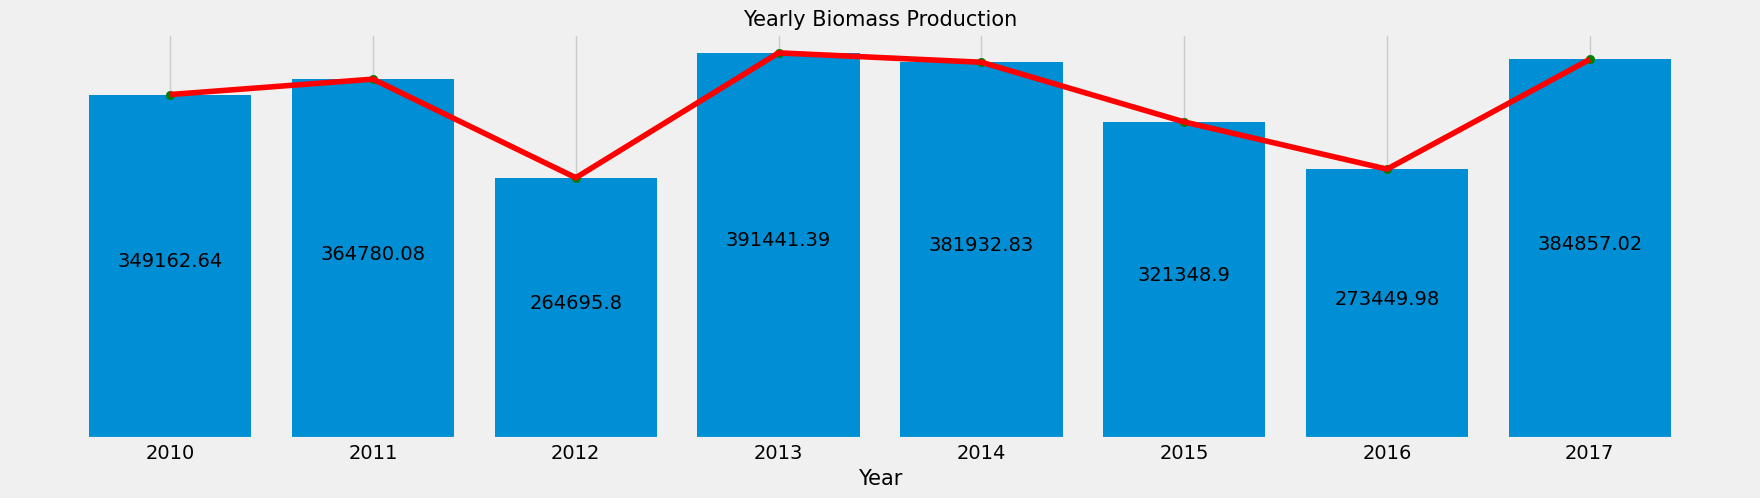

In [51]:
plt.figure(figsize = (20,5))
demandGrowth = DemandHistory[[f"201{x}" for x in range(8)]].sum()
plt.bar(demandGrowth.index, demandGrowth.values)
plt.plot(demandGrowth.index, demandGrowth.values, color="red")
plt.scatter(demandGrowth.index, demandGrowth.values, color="green")

# calling the function to add value labels
addlabels(demandGrowth.index, demandGrowth.values.round(2))
#plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Yearly Biomass Production", fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Biomas", fontsize = 15)

plt.show()

**OBSERVATION**

- What happen in Year `2012`, `2015` and `2016` compared to the remaining years? They seem to be the years with the lowest biomass.

- The biomass for year `2013` and `2014` are similar, is there anything common?

In [52]:
depotsIdx = SampleSubmission[SampleSubmission["data_type"].eq("depot_location")].source_index.values
refineryIdx = SampleSubmission[SampleSubmission["data_type"].eq("refinery_location")].source_index.values

depotLoc = DemandHistory.iloc[depotsIdx, [0,1]]
refineryLoc = DemandHistory.iloc[refineryIdx, [0,1]]

### **PROBLEM 1**: (BIOMASS FORECAST FOR YEAR 2018 AND 2019)


In [53]:
window_size = 3
train = create_train_data(df = DemandHistory,
                      window_size= window_size)

train.head()

,Latitude,Longitude,year1,year2,year3,Target,year_avg,year_std,year2_year1_change,year2_year1_diff,year3_year1_change,year3_year1_diff,year3_year2_change,year3_year2_diff
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,8.848831,0.363620,0.046347,0.392824,0.085708,0.726437,0.037617,0.333612
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,26.149180,2.274009,0.188165,4.521570,0.076432,1.836637,-0.094039,-2.684933
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,55.975020,10.675464,0.474654,21.279533,0.271028,12.150623,-0.138084,-9.128910
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,73.250755,11.535388,0.347596,20.846886,0.316504,18.982124,-0.023073,-1.864761
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,18.636346,3.686310,0.318982,4.674154,0.496457,7.274775,0.134555,2.600620


**2018**

In [54]:
test_2018 = pd.DataFrame()
test_2018["Latitude"] = DemandHistory["Latitude"]
test_2018["Longitude"] = DemandHistory["Longitude"]
test_2018[["year1", "year2", "year3"]] = DemandHistory[["2015", "2016", "2017"]]

test_2018["year_avg"] =test_2018[[f"year{x}" for x in range(1, 4)]].mean(1)
test_2018["year_std"] = test_2018[[f"year{x}" for x in range(1, 4)]].std(1)

years = [f"year{x}" for x in range(1,window_size+1)]

for index in range(len(years) -1):
  base_year = years[index]
  other_years  = years[index+1:]
  for yr_col in other_years:
    test_2018[f"{yr_col}_{base_year}_change"] = (test_2018[yr_col] - test_2018[base_year]) / test_2018[base_year]
    test_2018[f"{yr_col}_{base_year}_diff"] = test_2018[yr_col] - test_2018[base_year]

test_2018.head()

,Latitude,Longitude,year1,year2,year3,year_avg,year_std,year2_year1_change,year2_year1_diff,year3_year1_change,year3_year1_diff,year3_year2_change,year3_year2_diff
0,24.66818,71.33144,6.647325,7.387925,5.180296,6.405182,1.123557,0.111413,0.740601,-0.220695,-1.467028,-0.298816,-2.207629
1,24.66818,71.41106,27.361908,40.431847,42.126945,36.640233,8.079841,0.477669,13.069939,0.539620,14.765038,0.041925,1.695099
2,24.66818,71.49069,42.517117,59.181629,73.203232,58.300659,15.362015,0.391948,16.664513,0.721736,30.686115,0.236925,14.021603
3,24.66818,71.57031,70.203171,74.536720,101.067352,81.935748,16.709537,0.061729,4.333550,0.439641,30.864182,0.355940,26.530632
4,24.66818,71.64994,19.165791,16.531315,26.086885,20.594664,4.935432,-0.137457,-2.634476,0.361117,6.921095,0.578028,9.555571


In [55]:
features = [x for x in train.columns if x not in ["Target"]]

features = [ 'year1',
 'year2',
 'year3',
 'year_avg',
 'year_std',
 'year2_year1_change',
 'year2_year1_diff',
 'year3_year1_change',
 'year3_year1_diff',
 'year3_year2_change',
 'year3_year2_diff']

In [56]:
target = train['Target']
train_preds = np.zeros(len(train))
test_preds = np.zeros(len(test_2018))
#split_y = pd.qcut(target, 10, labels=False, duplicates='drop')

for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target)):
    print(50*'-')
    print(f'Fold {fold_+1} / {PARAMS.n_splits}' )
    X_trn, X_val = train.iloc[trn_idx][features], train.iloc[val_idx][features]
    X_test = test_2018[features]

    y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
    trn_data = lgb.Dataset(X_trn, y_trn)
    val_data = lgb.Dataset(X_val, y_val)

    clf = lgb.train(PARAMS.lgb_params, trn_data, valid_sets = [trn_data, val_data])

    predTrain = clf.predict(X_val, num_iteration=clf.best_iteration)
    train_preds[val_idx] = predTrain
    print(f"MAE : {mean_absolute_error(y_val, predTrain)}")

    predTest = clf.predict(X_test, num_iteration=clf.best_iteration)
    predTest[predTest < 0] = 0
    test_preds += predTest
    print(50*'-')

test_preds = test_preds / PARAMS.n_splits
print(f"Train MAE : {mean_absolute_error(target, train_preds)}")

--------------------------------------------------
Fold 1 / 5
MAE : 27.8177846302508
--------------------------------------------------
--------------------------------------------------
Fold 2 / 5
MAE : 25.90031272575824
--------------------------------------------------
--------------------------------------------------
Fold 3 / 5
MAE : 27.449534944421156
--------------------------------------------------
--------------------------------------------------
Fold 4 / 5
MAE : 28.1976817231546
--------------------------------------------------
--------------------------------------------------
Fold 5 / 5
MAE : 27.732191086789296
--------------------------------------------------
Train MAE : 27.41950102207482


In [57]:
DemandHistory["2018"] = test_preds

**2019**

In [58]:
test_2019 = pd.DataFrame()
test_2019["Latitude"] = DemandHistory["Latitude"]
test_2019["Longitude"] = DemandHistory["Longitude"]
test_2019[["year1", "year2", "year3"]] = DemandHistory[["2016", "2017", "2018"]]

test_2019["year_avg"] =test_2019[[f"year{x}" for x in range(1, 4)]].mean(1)
test_2019["year_std"] = test_2019[[f"year{x}" for x in range(1, 4)]].std(1)

years = [f"year{x}" for x in range(1,window_size+1)]

for index in range(len(years) -1):
  base_year = years[index]
  other_years  = years[index+1:]
  for yr_col in other_years:
    test_2019[f"{yr_col}_{base_year}_change"] = (test_2019[yr_col] - test_2019[base_year]) / test_2019[base_year]
    test_2019[f"{yr_col}_{base_year}_diff"] = test_2019[yr_col] - test_2019[base_year]

test_2019.head()

,Latitude,Longitude,year1,year2,year3,year_avg,year_std,year2_year1_change,year2_year1_diff,year3_year1_change,year3_year1_diff,year3_year2_change,year3_year2_diff
0,24.66818,71.33144,7.387925,5.180296,8.498162,7.022128,1.688909,-0.298816,-2.207629,0.150277,1.110237,0.640478,3.317865
1,24.66818,71.41106,40.431847,42.126945,37.735056,40.097949,2.214902,0.041925,1.695099,-0.066700,-2.696791,-0.104254,-4.391890
2,24.66818,71.49069,59.181629,73.203232,62.823869,65.069577,7.275557,0.236925,14.021603,0.061543,3.642240,-0.141788,-10.379362
3,24.66818,71.57031,74.536720,101.067352,90.811150,88.805074,13.378597,0.355940,26.530632,0.218341,16.274429,-0.101479,-10.256203
4,24.66818,71.64994,16.531315,26.086885,21.515226,21.377809,4.779267,0.578028,9.555571,0.301483,4.983911,-0.175247,-4.571659


In [59]:
DemandHistory["2019"] = clf.predict(test_2019[features], num_iteration=clf.best_iteration)

**BIOMASS FORECAST**

In [60]:
biomass_forecast_2018 = pd.DataFrame({
    "year":2018,
    "data_type": "biomass_forecast",
    "source_index": DemandHistory.index,
    "destination_index": 0,
    "value": DemandHistory["2018"]
})

biomass_forecast_2019 = pd.DataFrame({
    "year":2019,
    "data_type": "biomass_forecast",
    "source_index": DemandHistory.index,
    "destination_index": 0,
    "value": DemandHistory["2019"]
})

In [61]:
biomass_forecast_2018.head()

,year,data_type,source_index,destination_index,value
0,2018,biomass_forecast,0,0,8.498162
1,2018,biomass_forecast,1,0,37.735056
2,2018,biomass_forecast,2,0,62.823869
3,2018,biomass_forecast,3,0,90.811150
4,2018,biomass_forecast,4,0,21.515226


In [62]:
biomass_forecast_2019.head()

,year,data_type,source_index,destination_index,value
0,2019,biomass_forecast,0,0,7.826050
1,2019,biomass_forecast,1,0,40.698429
2,2019,biomass_forecast,2,0,71.067072
3,2019,biomass_forecast,3,0,99.276609
4,2019,biomass_forecast,4,0,20.779599


## **TASK 1**

**Test the constraints cases**


**Task 1 Library**

    └── src
        └── test_constraint.py   
            └── class constraintsTest()

**Empty DataFrame**

In [63]:
checker = constraintsTest(pd.DataFrame())
checker.constraints_check()

Error: The DataFrame is empty.


False

**Unmatched datatype**

In [64]:
checker = constraintsTest([1,2,3])
checker.constraints_check()

Error: Input is not a DataFrame.


False

**Correct Submission File**

In [65]:
checker = constraintsTest(SampleSubmission)
checker.constraints_check()

Constraint 1 Passed Successfuly: All values are greater than or equal to zero
Constraint 2 Passed Successfuly for year 2018: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 2 Passed Successfuly for year 2019: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 3 Passed Successfuly for year 2018: Total biomass reaching each depot is <= 20,000.
Constraint 3 Passed Successfuly for year 2019: Total biomass reaching each depot is <= 20,000.
Constraint 4 Passed Successfuly for year 2018: Total pellets reaching each refinery is <= 100,000.
Constraint 4 Passed Successfuly for year 2019: Total pellets reaching each refinery is <= 100,000.
Constraint 5 Passed Successfuly: Number of depots is <= to 25
Constraint 6 Passed Successfuly: Number of refineries is <= to 5
Constraint 7 Passed Successfuly for year 2018: 80% of the total forecasted biomass was processed by refineries
Constraint 7 Passed Successfuly fo

In [66]:
ss = SampleSubmission.copy()
ss["value"] = -89

In [67]:
checker = constraintsTest(ss)
checker.constraints_check()

Constraint 1 violated: All values are not greater than or equal to zero
Constraint 2 Passed Successfuly for year 2018: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 2 Passed Successfuly for year 2019: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 3 Passed Successfuly for year 2018: Total biomass reaching each depot is <= 20,000.
Constraint 3 Passed Successfuly for year 2019: Total biomass reaching each depot is <= 20,000.
Constraint 4 Passed Successfuly for year 2018: Total pellets reaching each refinery is <= 100,000.
Constraint 4 Passed Successfuly for year 2019: Total pellets reaching each refinery is <= 100,000.
Constraint 5 Passed Successfuly: Number of depots is <= to 25
Constraint 6 Passed Successfuly: Number of refineries is <= to 5
Constraint 7 violated for year 2018: 80% of the total forecasted biomass was not processed by refineries
Constraint 7 violated for year 2019: 80% of th

## **Problem 2**: Depots Location

## **TASK 2**: **Depot Location**

**Approach**

- Determine number of depots that will be needed based on the total yearly demand

- Divide the whole location into 4 clusters
  - Futher divide each clusters based on their demand and then assign depots based on the clusters

- Optimallly Place the depots
  - Center of Gravity method




    └── src
        ├── visualize.py
        │   └── plot_map()
        │
        ├── utils.py
        │   ├── cluster_data()
        │   └── haversine_distance()
        │
        └── depot_locator.py
             ├── center_of_gravity_method()
             └── FacilityLocator()


**Plotting Sample Submission Data**

In [68]:
DemandHistory["Clusters"] = cluster_data(df = DemandHistory, n_clusters = 4)

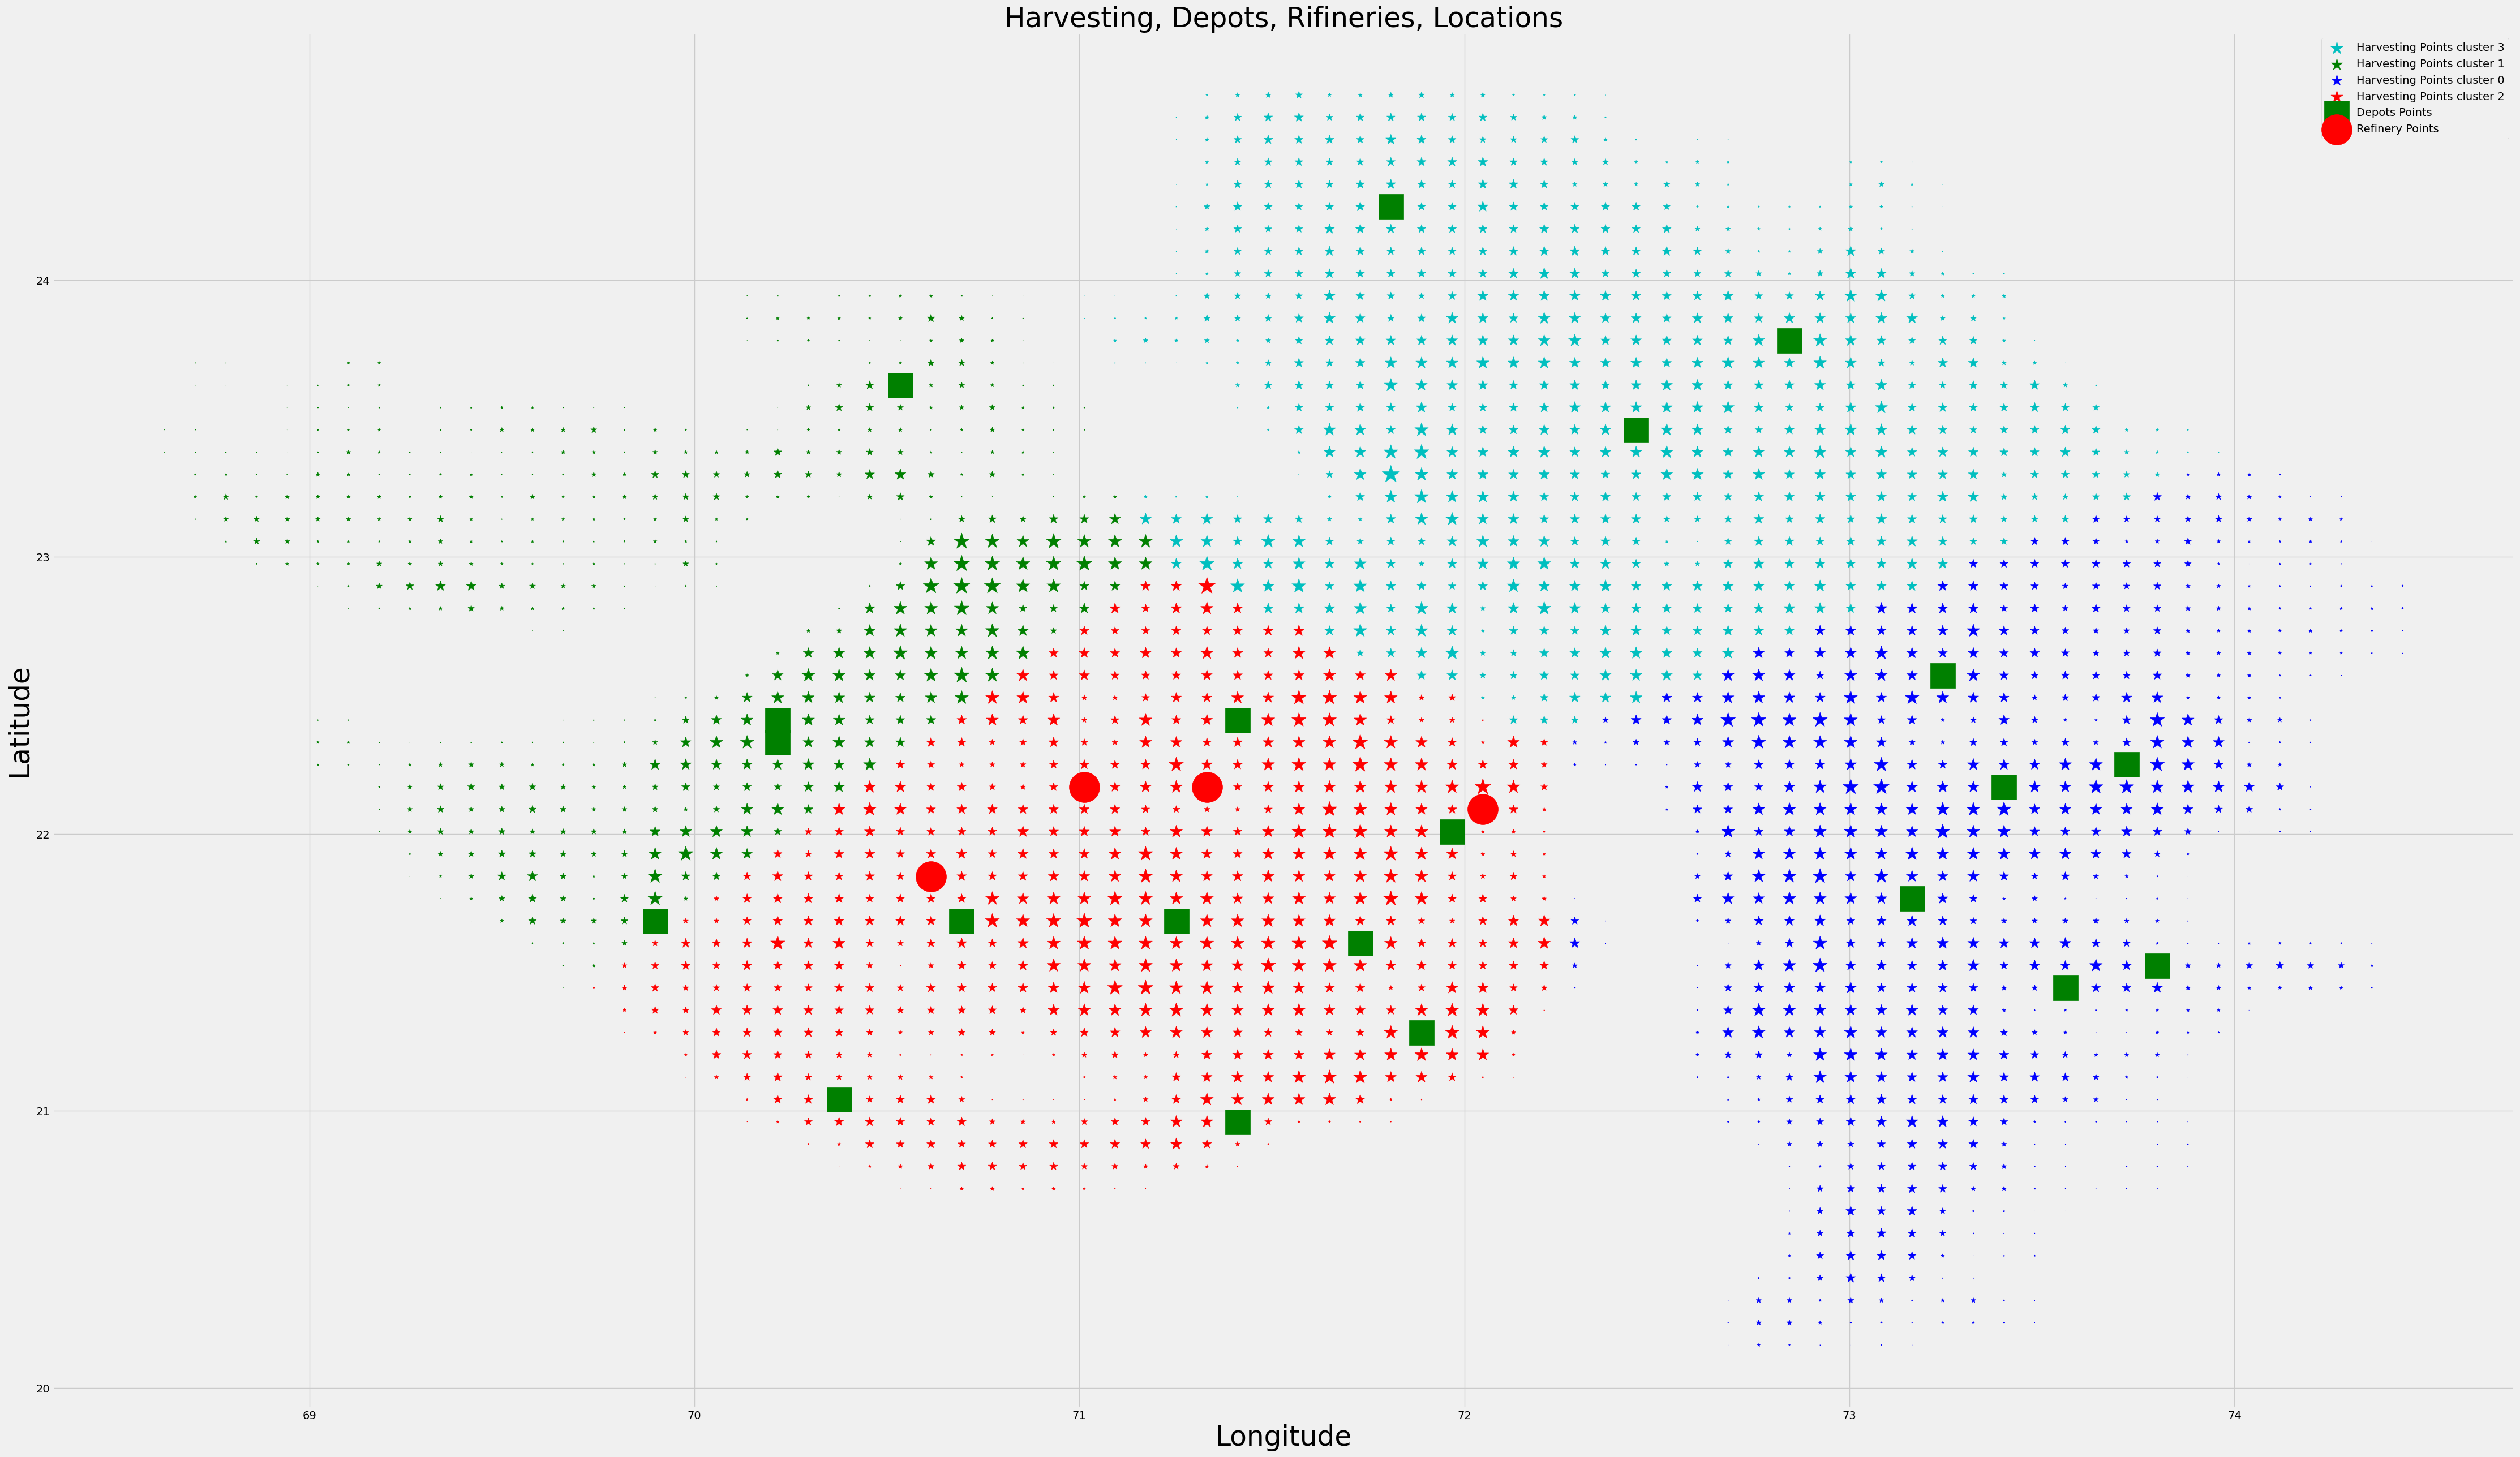

In [69]:
plot_map(df = DemandHistory,
        year = 2018,
        depot_data = depotLoc,
        refinery_data = refineryLoc,
        cluster_col = "Clusters")

**Locate Facilities**

Total Needed Facilities :  17
Needed Facilities : {
    "0": 3.834794690368109,
    "1": 2.231390668890332,
    "2": 5.494378600474758,
    "3": 4.575365869649216
}
Assigned Facilities : {
    "0": 4.0,
    "1": 2.0,
    "2": 5.0,
    "3": 5.0
}
The total assigned depots is lesser than the needed facilities by 1.0 depots
Remnant Facilities : {
    "0": 0,
    "1": 0.23139066889033222,
    "2": 0.4943786004747581,
    "3": 0
}
extra_facilities_needed: 1.0
Extra Facilities: [22.08897, 70.93331]


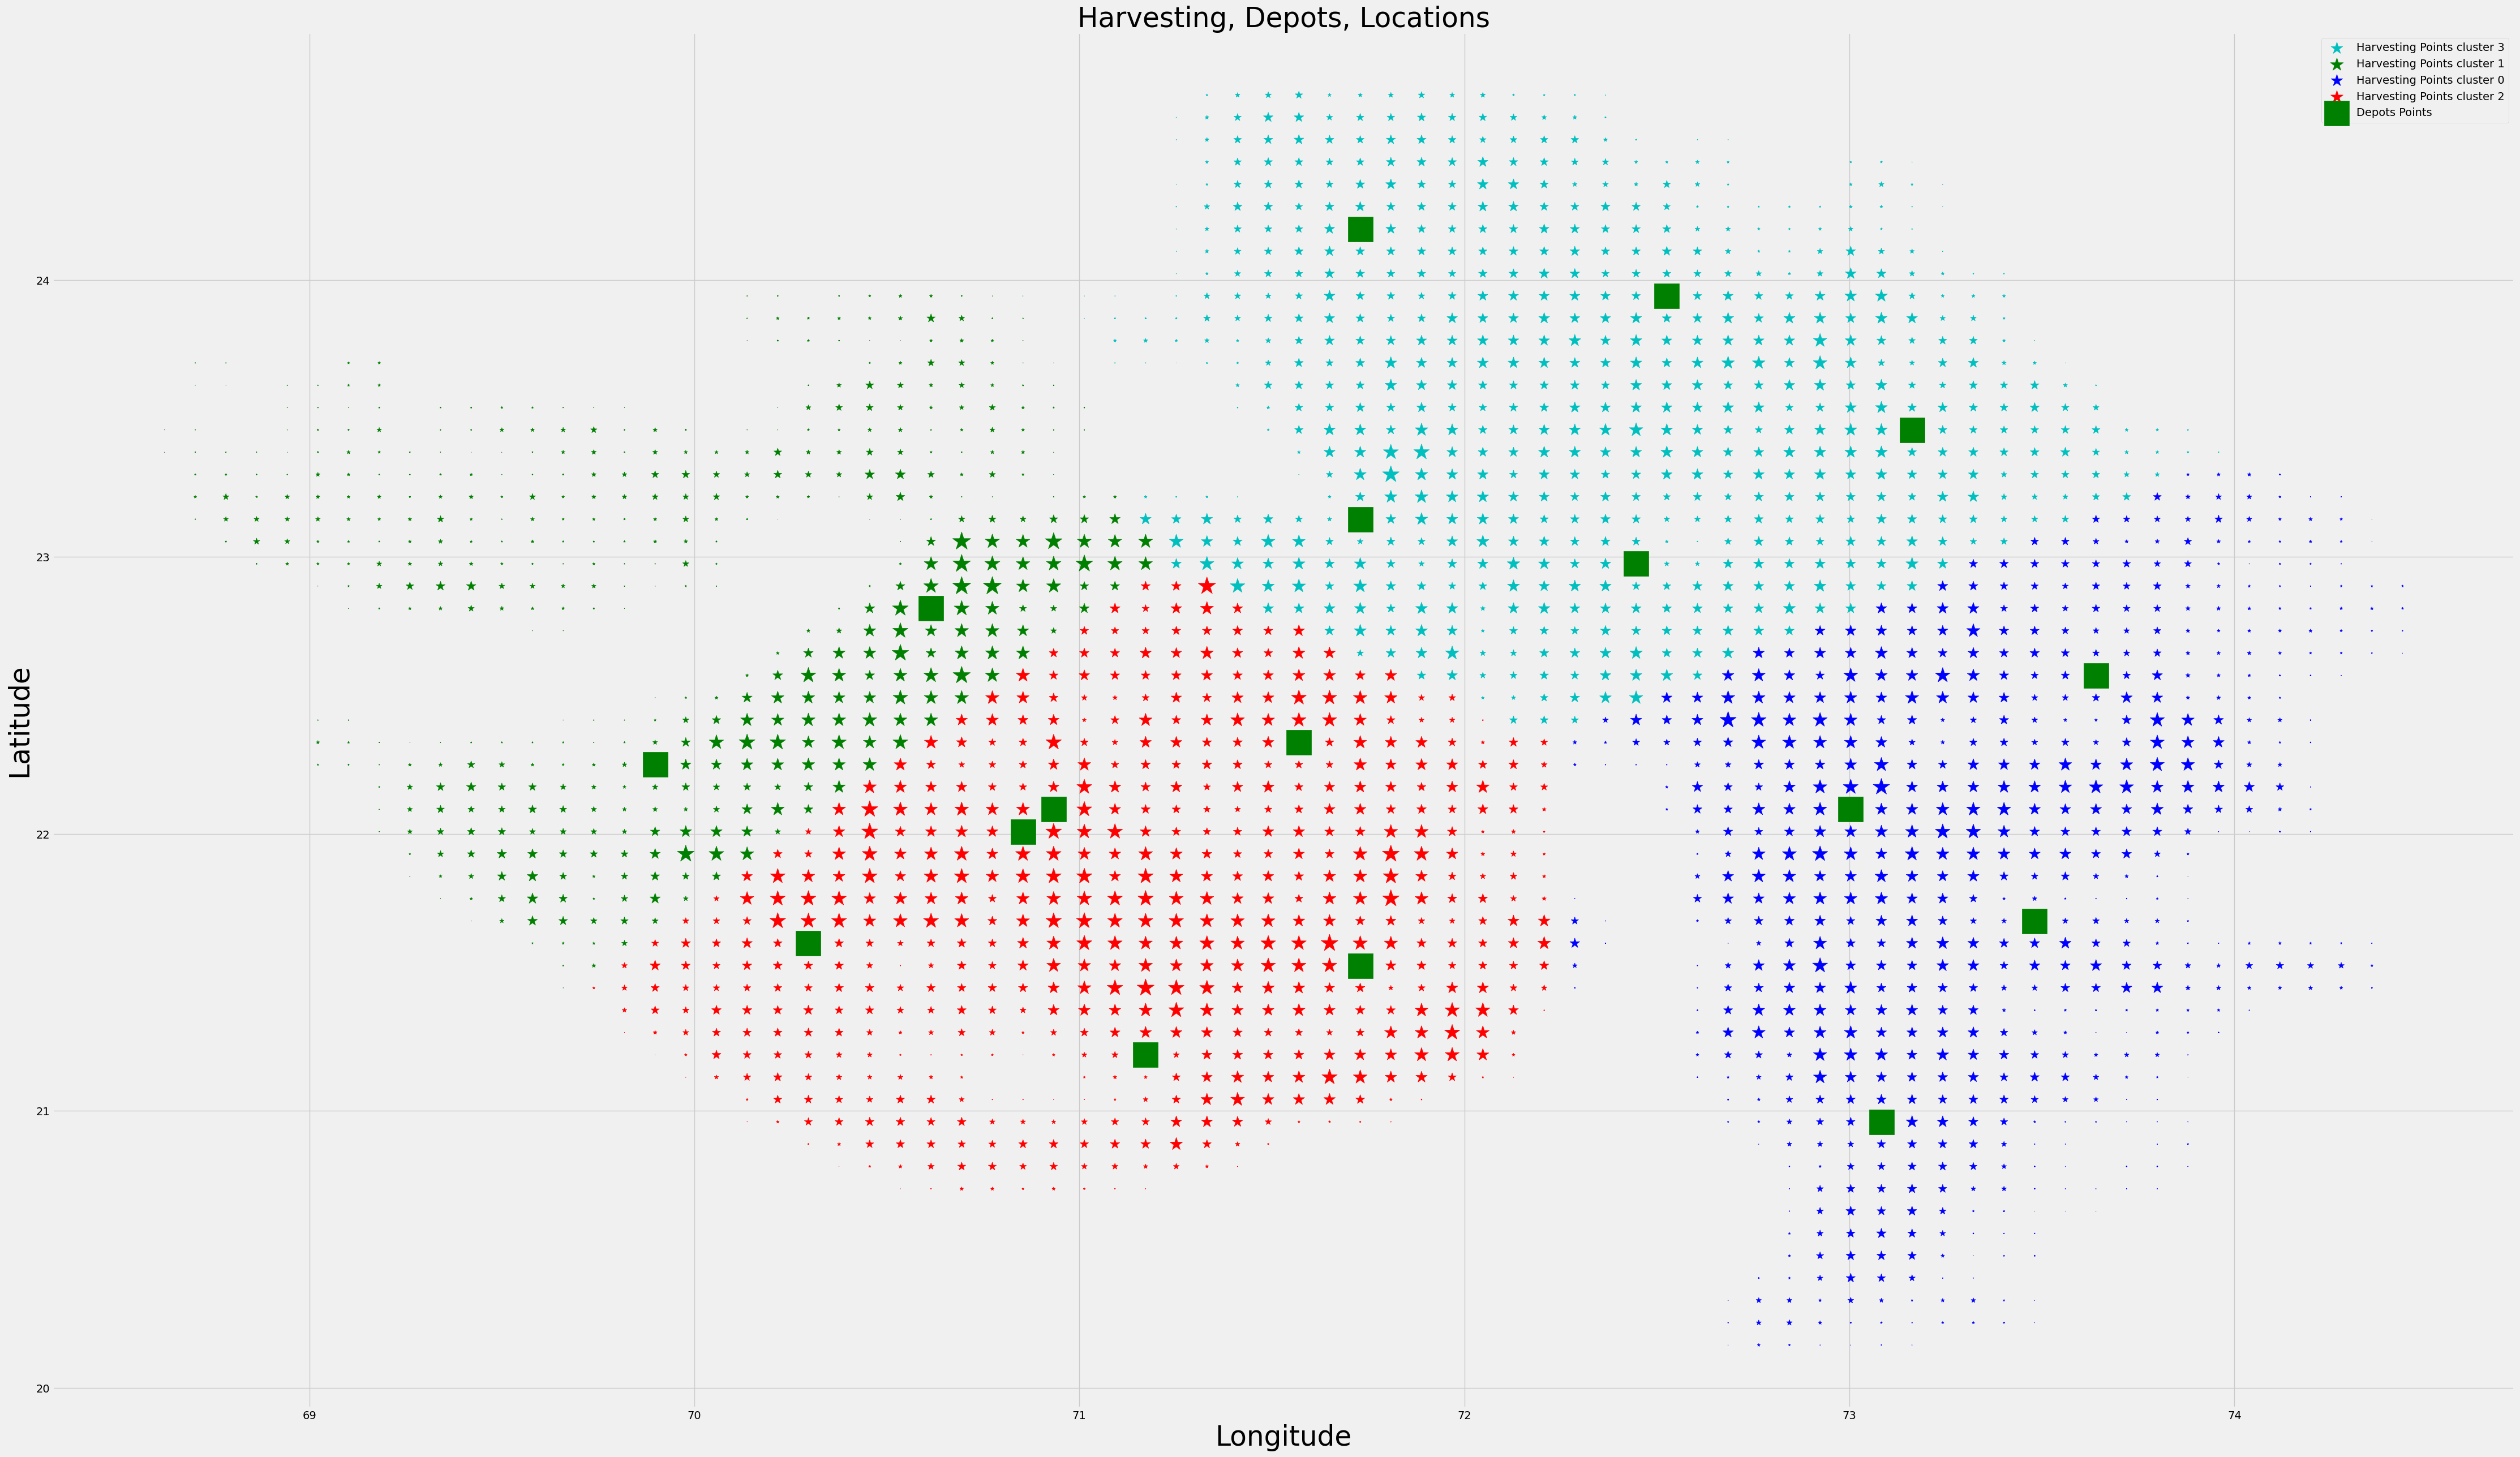

In [71]:
optimizedDepotsLocation = DepotLocator(df = DemandHistory,
                    years = ["2018","2019"],
                    facility_capacity = 20000,
                    facility_type = "depots")

In [73]:
optimizedDepotsLocation.head()

,Latitude,Longitude,year,data_type,destination_index,value,source_index
0,20.96056,73.08319,20182019,depot_location,0,0,2263
1,21.68597,73.48132,20182019,depot_location,0,0,1834
2,22.57257,73.64057,20182019,depot_location,0,0,1184
3,22.08897,73.00357,20182019,depot_location,0,0,1544
4,22.25017,69.89819,20182019,depot_location,0,0,1384


In [74]:
rows_idx = optimizedDepotsLocation["source_index"].values
DepotsDistanceMatrix = DistanceMatrix.iloc[:, rows_idx]

In [75]:
DepotsDistanceMatrix.head()

,2263,1834,1184,1544,1384,982,1581,1339,1924,2126,1849,123,880,223,503,740,1521
0,569.7491,489.4179,428.7333,420.6011,400.9091,283.3327,384.0210,346.9832,444.1114,494.6463,460.4236,84.1951,271.1470,164.7885,268.8247,207.7718,368.6922
1,567.5015,487.1702,426.4856,418.3534,398.6614,281.0850,381.7733,344.7355,441.8637,492.3986,458.1759,81.9474,268.8993,162.5408,266.5770,205.5241,366.4445
2,568.1042,487.7730,427.0884,418.9561,406.6712,289.0948,389.7830,345.3383,442.4664,493.0014,466.1856,82.5501,269.5020,163.1436,267.1798,222.1663,374.4543
3,567.2946,486.9634,426.2788,418.1465,416.6026,299.0262,409.3422,338.6215,495.0026,486.2846,476.1171,75.8334,280.0572,162.3340,266.3702,215.4496,394.5630
4,549.8536,469.5224,408.8378,400.7055,417.2021,299.6257,404.5629,333.8422,477.5616,481.5053,476.7166,71.0540,262.6162,144.8930,248.9292,210.6702,389.7837


## **Problem 3**: Refineries Location

## **TASK 3** (Completed)

**Refinery Location** (P-median Approach)

The p-median problem is a classic facility location optimization problem that involves locating p facilities among a set of potential sites to minimize the total cost or distance between the facilities and demand points. Here's a formulation of the p-median problem:

**Parameters:**
- **N:** The set of potential refinery locations, indexed by  *$i = 1, 2, \ldots,  n$*
- **M:** The set of depot points, indexed by  *$j = 1, 2, \ldots,  m.$*
- **$ d_{ij} $:** The distance (cost) between potential refineries*i* and demand point *j*.
- **p:** The number of facilities to be located.
- **$ C_{ref} $**: Maximum amount of depots that can be served by 1 refinery = 5

**Variables:**
- **$ x_{ij} $:** Binary variable indicating whether refinery *i* serves depot *j* (1 if it does, 0 otherwise).
- **$ y_i $:** Binary variable indicating whether refinery *i* is open (1 if it is, 0 otherwise).

**Objective:** (Minimize the total cost)

  - Minimize:  $\sum_{i=1}^{n} \sum_{j=1}^{m} d_{ij} \cdot x_{ij}
\$

**Constraints:**
- Each depot point must be served by exactly one open refinery:

$\sum_{j=1}^{m} x_{ij} = 1 \quad \text{for } i = 1, 2, \ldots, n$

- Each refinery must serve less or exactly the maximum amount of depots it can serve:

$\sum_{i=1}^{n} x_{ij} \leq C_{ref} \quad \text{for } j = 1, 2, \ldots, m$


- The number of open facilities must be equal to **p**:


$\sum_{i=1}^{n} y_i = p
\$

- If a facility is open, it must serve the associated demand points:


$x_{ij} \leq y_i \quad \text{for } i = 1, 2, \ldots, n, \quad j = 1, 2, \ldots, m
\$

- Binary constraints on variables:


$x_{ij} \in \{0, 1\} \quad \text{for } i = 1, 2, \ldots, n, \quad j = 1, 2, \ldots, m
\$

$y_i \in \{0, 1\} \quad \text{for } i = 1, 2, \ldots, n
\$

Solution:
Facility 437 - Demand Points: 123, 880, 223, 503, 740
Facility 1485 - Demand Points: 2263, 1834, 1184, 1544
Facility 1520 - Demand Points: 1384, 982, 1581, 1849, 1521
Facility 1864 - Demand Points: 1339, 1924, 2126
Open Facilities: ['437', '1485', '1520', '1864']


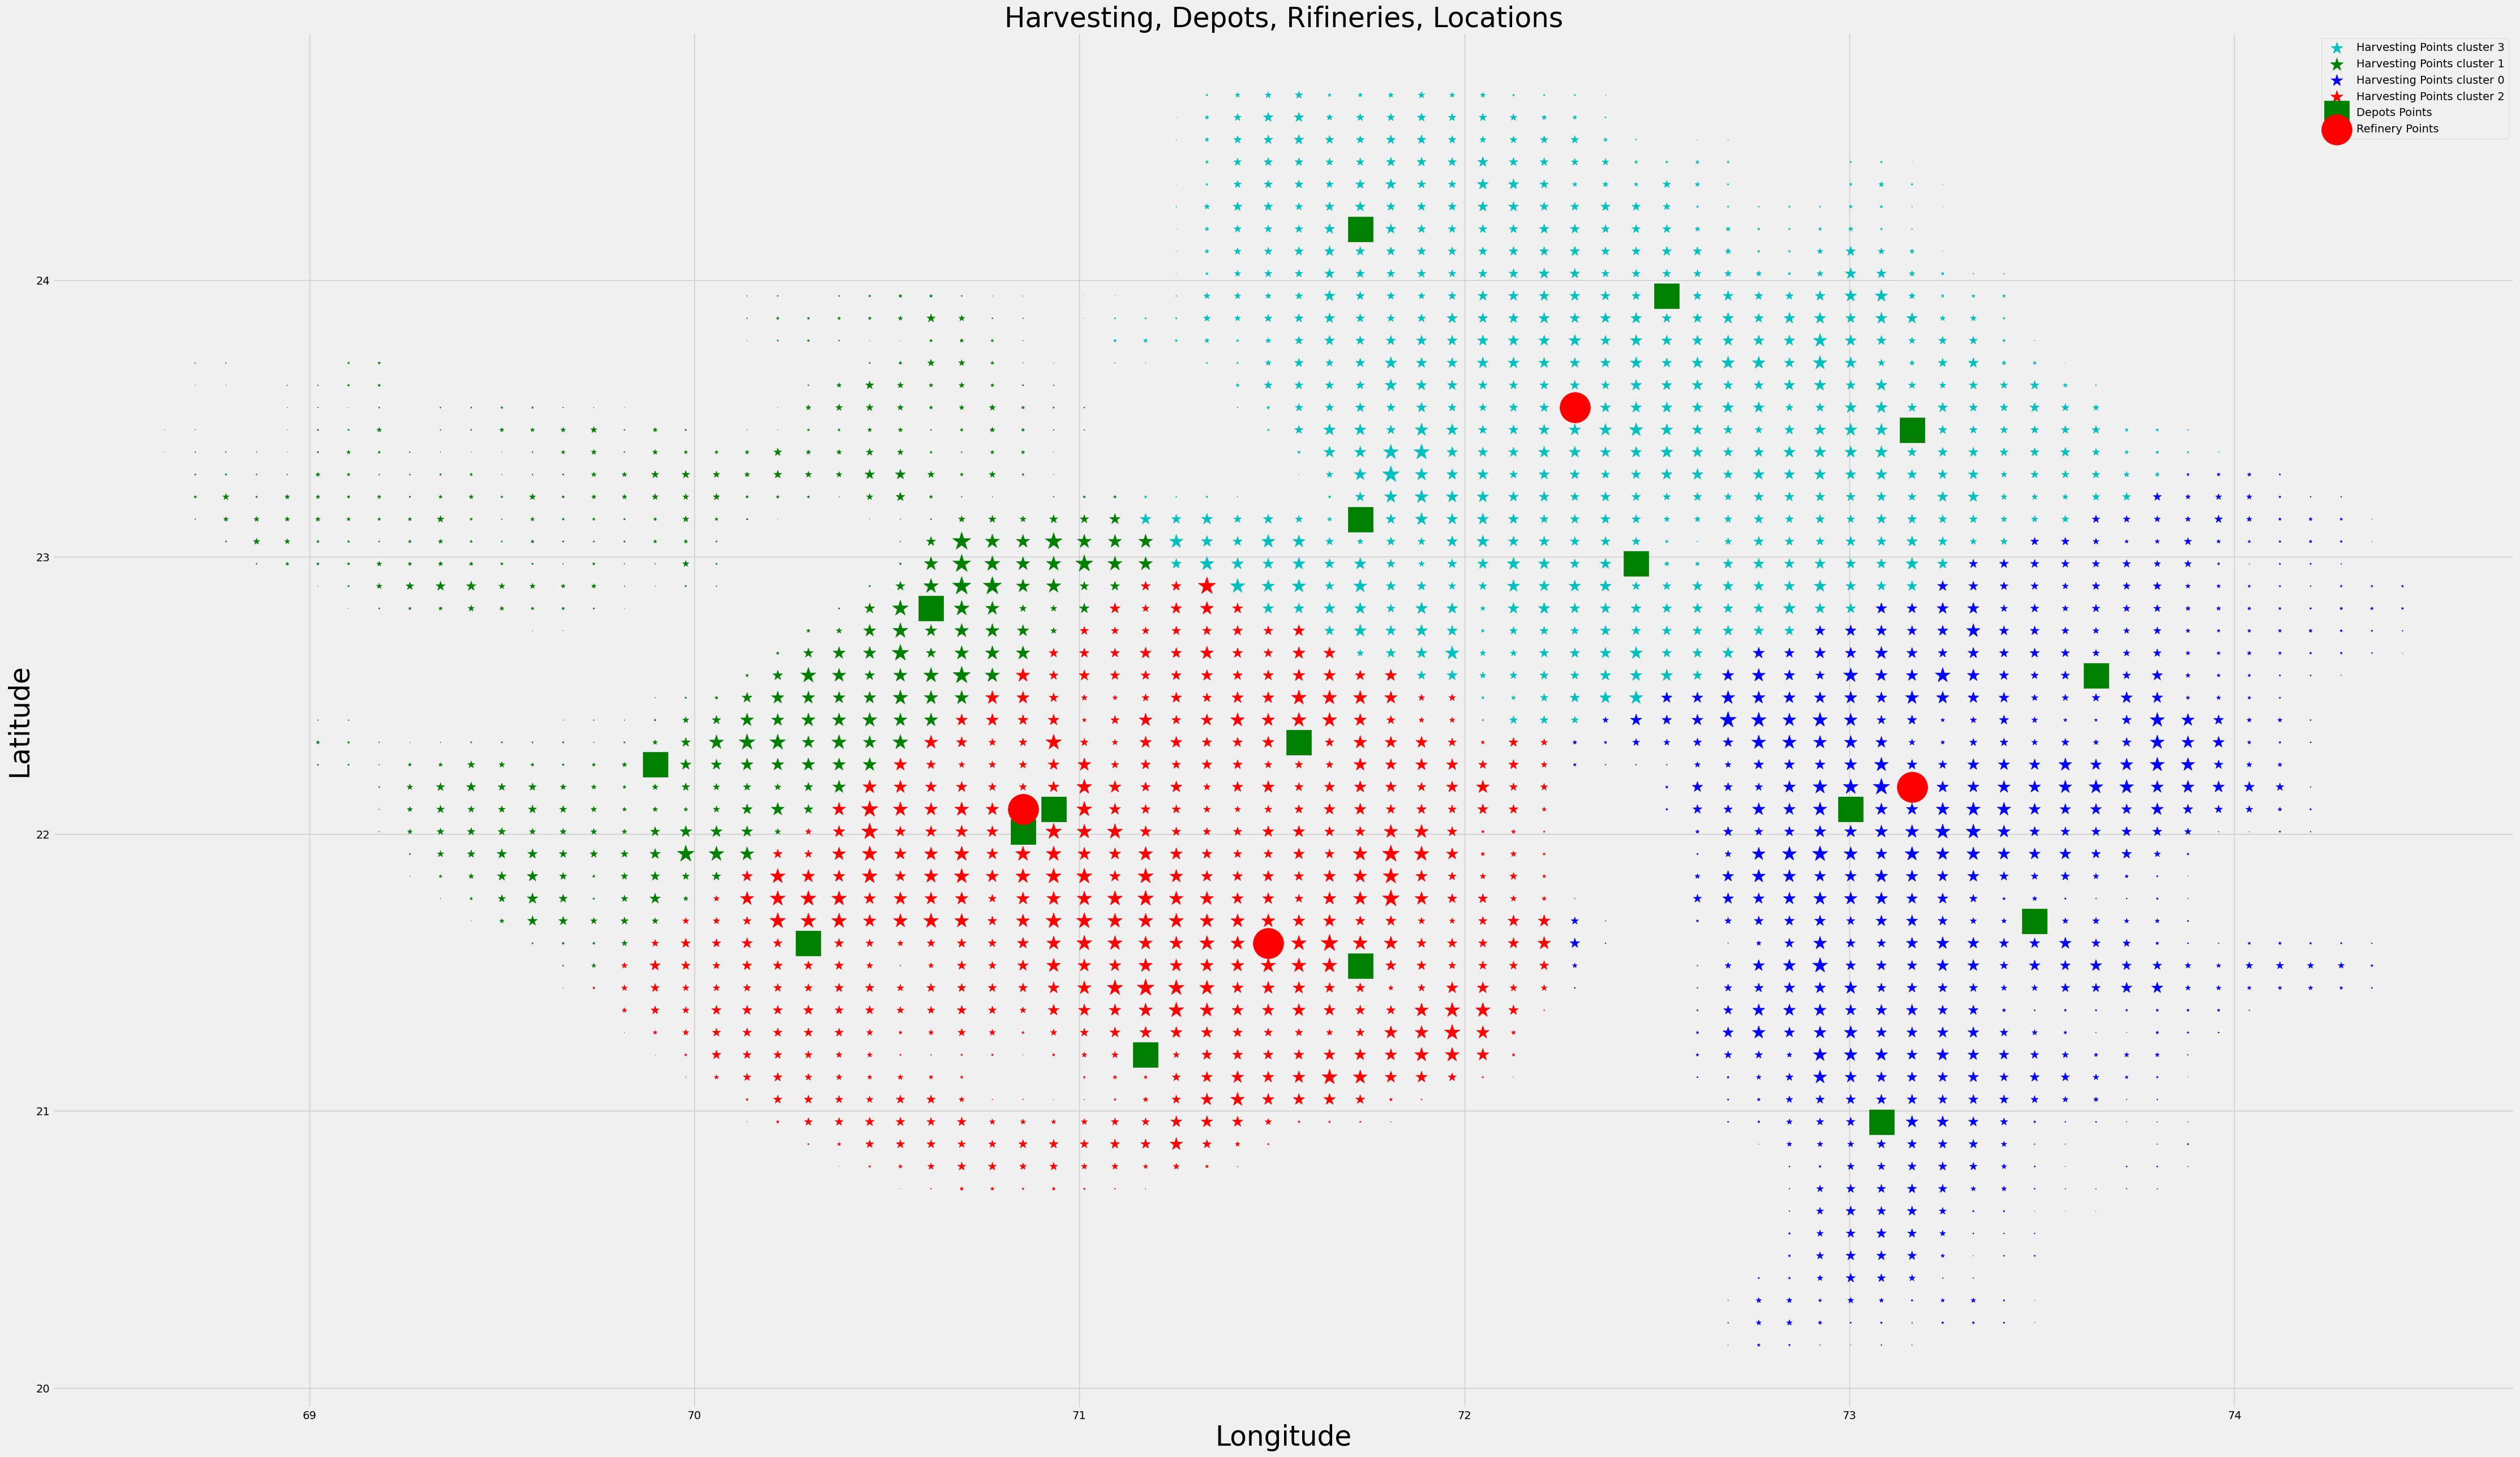

In [77]:
optimizedRefineryLocation, facilities_allocation = RefineryLocator(demand_history = DemandHistory,
                   depots_location = optimizedDepotsLocation,
                   distance_matrix = DistanceMatrix,
                   years = ["2018", "2019"],
                   depot_apacity = 20000,
                   refinery_apacity = 100000)

In [78]:
optimizedRefineryLocation

,source_index,Latitude,Longitude,year,data_type,destination_index,value
0,437,23.53978,72.28694,20182019,refinery_location,0,0
1,1485,22.16957,73.16282,20182019,refinery_location,0,0
2,1520,22.08897,70.85369,20182019,refinery_location,0,0
3,1864,21.60537,71.49069,20182019,refinery_location,0,0


In [79]:
facilities_allocation.head()

,source_index,destination_index,data_type
0,123,437,pellet_demand_supply
1,880,437,pellet_demand_supply
2,223,437,pellet_demand_supply
3,503,437,pellet_demand_supply
4,740,437,pellet_demand_supply


https://medium.com/@telmosubirar/linear-programming-optimizing-solutions-with-python-using-pulp-e0c4379696c8


https://www.youtube.com/watch?v=ufYtueq2DCw

## **Problem 4**: Distribute biomass from all harvesting locations to the different located Depots

## **TASK 4** (In Progress)

**Biomass Distribution** (Transportation Model Approach)

**Variables and Parameters:**

- $Biomass_{ij}$: Biomass demand-supply matrix
- $Dist_{ij}$: Cost of transporting one unit of biomass from Harvesting Location *i* to Depot *j*.
- $Biomass_{forecast, i}$: Supply capacity of Harvesting site *i*.
- $Cap_{depot}$: Maximum yearly processing capacity of a depot (20,000).

**Decision Variables:**

Let $ Biomass_{ij} $ represent the quantity of biomass transported from Harvesting Location *i* to Depot *j*.

**Objective Function:**

Minimize the total transportation cost:

$\text{Minimize} \sum_{i} \sum_{j} Dist_{ij} \cdot Biomass_{ij} $

**Constraints:**
****

**Biomass Supply Constraints:**

The total supply from each harvesting site should not exceed its capacity:

$\sum_{j} Biomass_{ij} \leq Biomass_{forecast, i} \quad \text{for each harvesting point } i$

The total supply from each harvesting site must exceed 80% of its capacity:

$\sum_{j} Biomass_{ij} \geq 0.8 \cdot Biomass_{forecast, i} \quad \text{for each harvesting point } i$

****

**Biomass Demand Constraints:**

The total biomass supplied to each depot should be less than or equal to its capacity:

$\sum_{i} Biomass_{ij} \leq Cap_{depot} \quad \text{for each depot } j$

****

**Non-Negativity Constraints:**

The quantities of biomass transported cannot be negative:

$Biomass_{ij} \geq 0 \quad \text{for all } i \text{ and } j$

****

In [81]:
biomass_supply_2018 = BiomassDemandSupply(demand_history =DemandHistory,
                        distances_df = DepotsDistanceMatrix,
                        year = 2018,
                        processing_capacities = 20000)

Problem Status: 1
Minimum Cost Value: 17076422.37453679


In [82]:
biomass_supply_2019 = BiomassDemandSupply(demand_history =DemandHistory,
                        distances_df = DepotsDistanceMatrix,
                        year = 2019,
                        processing_capacities = 20000)

Problem Status: 1
Minimum Cost Value: 17739674.946413312


## **Problem 5**: Distribute pallete from all depots to the different located Refineries

## **TASK 5** (In Progress)

**Pellete Distribution** (Transportation Model Approach)

**Variables and Parameters:**

- $Pellete_{ij}$: Pellete demand-supply matrix
- $Dist_{ij}$: Cost of transporting one unit of Pellete from Depot *i* to Refinery *j*.
- $Pellete_{cap, i}$: Supply capacity of Depot *i*.
- $Cap_{refinery}$: Maximum yearly processing capacity of a Refinery (100,000).

**Decision Variables:**

Let $ Pellete_{ij} $ represent the quantity of Pellete transported from Depot *i* to Refinery *j*.

**Objective Function:**

Minimize the total transportation cost:

$\text{Minimize} \sum_{i} \sum_{j} Dist_{ij} \cdot Pellete_{ij} $

**Constraints:**
****

**Pellete Supply Constraints:**

The total supply from each depot should not exceed its capacity:

$\sum_{j} Pellete_{ij} \leq Pellete_{cap, i} \quad \text{for each depot } i$

The total supply from each depot must exceed 80% of its capacity:

$\sum_{j} Pellete_{ij} \geq 0.8 \cdot Pellete_{cap, i} \quad \text{for each depot } i$

****

**Pellete Demand Constraints:**

The total demand at each refinery should be less than or equal to its capacity:

$\sum_{i} Pellete_{ij} \leq Cap_{refinery} \quad \text{for each refinery } j$

****

**Non-Negativity Constraints:**

The quantities of Pellete transported cannot be negative:

$Pellete_{ij} \geq 0 \quad \text{for all } i \text{ and } j$

****

In [83]:
mapper_2018 = biomass_supply_2018.groupby("destination_index").sum()["value"].to_dict()
pellete_supply_2018 = facilities_allocation.copy()
pellete_supply_2018["year"] = 2018
pellete_supply_2018["value"] = pellete_supply_2018["source_index"].map(mapper_2018)

In [84]:
mapper_2019 = biomass_supply_2019.groupby("destination_index").sum()["value"].to_dict()
pellete_supply_2019 = facilities_allocation.copy()
pellete_supply_2019["year"] = 2019
pellete_supply_2019["value"] = pellete_supply_2019["source_index"].map(mapper_2019)

## **Create Submission File**

In [85]:
submissionColumns = ['year', 'data_type', 'source_index', 'destination_index', 'value']

In [86]:
baseline_solution = pd.concat([biomass_supply_2018[submissionColumns],
          biomass_supply_2019[submissionColumns],
          pellete_supply_2018[submissionColumns],
          pellete_supply_2019[submissionColumns],
          biomass_forecast_2018[submissionColumns],
          biomass_forecast_2019[submissionColumns],
          optimizedRefineryLocation[submissionColumns],
          optimizedDepotsLocation[submissionColumns]])

In [87]:
checker = constraintsTest(baseline_solution)
checker.constraints_check()

Constraint 1 Passed Successfuly: All values are greater than or equal to zero
Constraint 2 Passed Successfuly for year 2018: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 2 Passed Successfuly for year 2019: Amount of biomass from each harvesting site is <= to the site’s forecasted biomass.
Constraint 3 Passed Successfuly for year 2018: Total biomass reaching each depot is <= 20,000.
Constraint 3 Passed Successfuly for year 2019: Total biomass reaching each depot is <= 20,000.
Constraint 4 Passed Successfuly for year 2018: Total pellets reaching each refinery is <= 100,000.
Constraint 4 Passed Successfuly for year 2019: Total pellets reaching each refinery is <= 100,000.
Constraint 5 Passed Successfuly: Number of depots is <= to 25
Constraint 6 Passed Successfuly: Number of refineries is <= to 5
Constraint 7 Passed Successfuly for year 2018: 80% of the total forecasted biomass was processed by refineries
Constraint 7 Passed Successfuly fo

In [88]:
baseline_solution.to_csv(f"Submission.csv", index=False)